In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [2]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar):
    Ncut = 201
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [3]:
def hyperRamseyPhaseJumpM(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03):
    #pulse(t, Omega0, delta, phi0, phi1):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t2/3.0, -Omega02, delPrime, 0.0, 0.0)
    pulse3 = pulse(t2/3.0, Omega03, delPrime, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    
    return pulse3@pulse2@freeEvo@pi2PhaseInj@pulse1@psi0

def hyperRamseyPhaseJumpP(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03):
    #pulse(t, Omega0, delta, phi0, phi1):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t2/3.0, -Omega02, delPrime, 0.0, 0.0)
    pulse3 = pulse(t2/3.0, Omega03, delPrime, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    
    return pulse3@pulse2@freeEvo@pi2PhaseInj@pulse1@psi0

def HRJumperrSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03):
    RhoeeP = rhoee(hyperRamseyPhaseJumpP(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,Omega03))
    RhoeeM = rhoee(hyperRamseyPhaseJumpM(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,Omega03))
    return RhoeeP - RhoeeM

def HRJumpThermP(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03, nbar1, nbar2, nbar3):
    #thermPulse(psi0, t, Omega0, delPrime, eta, nbar):
    eta = 0.01
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    intState = freeEvo@pi2PhaseInj@thermPulse(psi0, t1, Omega01, delPrime, eta, nbar1)
    return thermPulse(thermPulse(intState, 2.0*t2/3.0, -Omega02, delPrime, eta, nbar2), t2/3.0, Omega03, delPrime, eta, nbar3)

def HRJumpThermM(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03, nbar1, nbar2, nbar3):
    #thermPulse(psi0, t, Omega0, delPrime, eta, nbar):
    eta = 0.01
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = freeEvo@pi2PhaseInj@thermPulse(psi0, t1, Omega01, delPrime, eta, nbar1)
    return thermPulse(thermPulse(intState, 2.0*t2/3.0, -Omega02, delPrime, eta, nbar2), t2/3.0, Omega03, delPrime, eta, nbar3)

def HRThermJumperrSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02, Omega03, nbar1, nbar2, nbar3):
    RhoeeP = rhoee(HRJumpThermP(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,Omega03,nbar1,nbar2,nbar3))
    RhoeeM = rhoee(HRJumpThermM(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02,Omega03,nbar1,nbar2,nbar3))
    return RhoeeP - RhoeeM

In [4]:
nbarx = 10.0
nbary = 0.0
nbarz = 0.0
Ncut = 51
etax = 0.05
etay = 0.00
etaz = 0.00
ts = np.linspace(0.0,5.0,20)
rhoDD = [0.0]*np.size(ts)
rhoDD2 = [0.0]*np.size(ts)
rhoDD3 = [0.0]*np.size(ts)
psi0 = psi(1.0,0.0)

Omegas = np.zeros((Ncut,Ncut,Ncut))
for nx in range(Ncut):
    print(ii)
    for ny in range(Ncut):
        for nz in range(Ncut):
            Omegas[nx,ny,nz] = Omega(nx,0,etax)*Omega(ny,0,etay)*Omega(nz,0,etaz)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [15]:
rhoDD = [0.0]*np.size(ts)
rhoDD2 = [0.0]*np.size(ts)
rhoDD3 = [0.0]*np.size(ts)
for ii in range(np.size(ts)):
    print(ii)
    for nx in range(Ncut):
        print(nx)
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                rhoDD2[ii] += Probxy*prob(nz,nbarz)*rhoee(pulse(ts[ii], Omegas[nx,ny,nz], 0.0, 0.0, 0.0)@psi0)
                rhoDD3[ii] += Probxy*prob(nz,nbarz)*(np.sin(Omegas[nx,ny,nz]*ts[ii]))**2

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


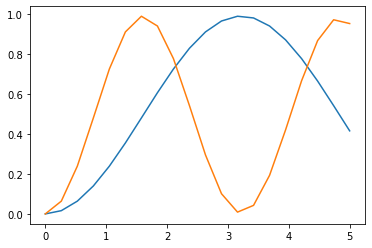

In [16]:
plt.plot(ts,rhoDD2)
plt.plot(ts,rhoDD3)

Now testing to see what value of Ncut is good enough for a given nbar.

In [41]:
nbar = 10.0
eta = 0.05
Omega0 = np.pi
ts = np.linspace(0.0,5.0,20)
rhoDD1a = 02.
202.3rhoDD1b = np.zeros(np.size(ts))
rhoDD2a = np.zeros(np.size(ts))
rhoDD2b = np.zeros(np.size(ts))
rhoDD3a = np.zeros(np.size(ts))
rhoDD3b = np.zeros(np.size(ts))
rhoDD4a = np.zeros(np.size(ts))
rhoDD4b = np.zeros(np.size(ts))
psi0 = psi(1.0,0.0)
Ncut1 = 50
Ncut2 = 100
Ncut3 = 200
Ncut4 = 300

for ii in range(np.size(ts)):
    print(ii)
    for n in range(Ncut1):
        rhoDD1a[ii] += prob(n,nbar)*(np.sin(Omega0*0.5*Omega(n,0,eta)*ts[ii]))**2
        rhoDD1b[ii] += prob(n,nbar)*rhoee(pulse(ts[ii], Omega0*Omega(n,0,eta), 0.0, 0.0, 0.0)@psi0)
    for n in range(Ncut2):
        rhoDD2a[ii] += prob(n,nbar)*(np.sin(Omega0*0.5*Omega(n,0,eta)*ts[ii]))**2
        rhoDD2b[ii] += prob(n,nbar)*rhoee(pulse(ts[ii], Omega0*Omega(n,0,eta), 0.0, 0.0, 0.0)@psi0)
    for n in range(Ncut3):
        rhoDD3a[ii] += prob(n,nbar)*(np.sin(Omega0*0.5*Omega(n,0,eta)*ts[ii]))**2
        rhoDD3b[ii] += prob(n,nbar)*rhoee(pulse(ts[ii], Omega0*Omega(n,0,eta), 0.0, 0.0, 0.0)@psi0)
    for n in range(Ncut4):
        rhoDD4a[ii] += prob(n,nbar)*(np.sin(Omega0*0.5*Omega(n,0,eta)*ts[ii]))**2
        rhoDD4b[ii] += prob(n,nbar)*rhoee(pulse(ts[ii], Omega0*Omega(n,0,eta), 0.0, 0.0, 0.0)@psi0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


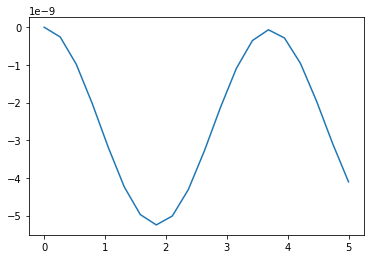

In [44]:
#plt.plot(ts,rhoDD1b-rhoDD4b)
#plt.plot(ts,rhoDD2b-rhoDD4b)
plt.plot(ts,rhoDD3b-rhoDD4b)

In [40]:
prob(150,10)

5.619588836731331e-08